# Project Telco

* Learn to discern what turns customers to churn

## Goal

* Discover drivers of churn of Telco customers
* Use drivers to develop a machine learning model to classify churn as a customer ending their contract or not ending (renewing) their contract with Telco

## Imports

In [96]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# import warnings
# warnings.filterwarnings("ignore")

from scipy import stats

import wrangle as w
import explore as e
import model as m

## Acquire

* Data acquired from Codeup MySQL DB
* Data initially acquired on 25 Apr 2023
* It contained 7,043 rows and 21 columns before cleaning
* Each row represents a unique customer of Telco
* Each column represents an element of the customer account

## Prepare

**Prepare Actions**:

* Removed columns that did not contain useful information
* Renamed columns to promote readability
* Checked for nulls in the data
    - total_charges nulls matched tenure of 0, therefore changed nulls to 0
* Checked that column data types were appropriate
* Added additional features to investigate:
    - has internet package
* Encoded categorical variables
    - turned 'Yes'/'No' to 1/0
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn'
* Outliers have not been removed for this iteration of the project

In [2]:
# acquire, clean, and prepare
df = w.wrangle_telco_data()
df.head()

csv file found and loaded
data cleaned and prepped


,customer_id,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service_type,online_security,online_backup,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,Female,0,1,1,1,No,DSL,No,Yes,...,1,0,0,1,0,0,0,0,0,1
1,0003-MKNFE,Male,0,0,0,1,Yes,DSL,No,No,...,0,0,1,0,0,0,0,0,0,1
2,0004-TLHLJ,Male,0,0,0,1,No,Fiber optic,No,No,...,0,0,0,0,0,1,0,0,1,0
3,0011-IGKFF,Male,1,1,0,1,No,Fiber optic,No,Yes,...,1,0,1,0,0,1,0,0,1,0
4,0013-EXCHZ,Female,1,1,0,1,No,Fiber optic,No,No,...,1,0,0,0,0,1,0,0,0,1


In [3]:
# split into train, validate, and test
train, validate, test = w.split_data(df, 'churn')

data split
train -> (4225, 43); 59.99%
validate -> (1409, 43); 20.01%
test -> (1409, 43); 20.01%


#### A brief look at the data

In [4]:
# show head of train data
train.head()

,customer_id,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service_type,online_security,online_backup,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
2332,3338-CVVEH,Male,0,0,0,1,Yes,Fiber optic,No,No,...,1,0,1,0,0,1,0,0,1,0
5275,7442-YGZFK,Male,0,0,0,1,Yes,DSL,No,No,...,0,0,0,0,0,0,0,1,0,0
6429,9102-OXKFY,Male,0,0,0,1,Yes,DSL,No,No,...,0,0,0,0,1,0,0,1,0,0
89,0141-YEAYS,Female,1,0,0,1,Yes,Fiber optic,No,Yes,...,0,0,0,0,0,1,0,0,0,0
6412,9079-YEXQJ,Female,0,0,0,1,Yes,Fiber optic,No,Yes,...,1,0,1,0,0,1,0,0,1,0


#### A summary of the data

In [5]:
# describe train data, maybe transpose
train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,4225.0,0.159053,0.365769,0.0,0.00,0.00,0.00,1.00
partner,4225.0,0.479527,0.499640,0.0,0.00,0.00,1.00,1.00
dependents,4225.0,0.305562,0.460700,0.0,0.00,0.00,1.00,1.00
phone_service,4225.0,0.907219,0.290160,0.0,1.00,1.00,1.00,1.00
paperless_billing,4225.0,0.604260,0.489067,0.0,0.00,1.00,1.00,1.00
monthly_charges,4225.0,65.273243,30.218179,18.4,36.45,70.75,90.35,118.75
total_charges,4225.0,2320.103183,2297.297588,0.0,392.65,1414.80,3902.45,8684.80
tenure,4225.0,32.562367,24.755164,0.0,9.00,29.00,56.00,72.00
churn,4225.0,0.265325,0.441559,0.0,0.00,0.00,1.00,1.00
female,4225.0,0.496095,0.500044,0.0,0.00,0.00,1.00,1.00


## Explore

* Is Churn independent from payment type?
* Is Churn independent from internet Service type?
* Is Churn independent from tech support?
* Is Churn independent from a customer having at least one internet package?

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two

In [6]:
# * How often does a customer churn?
# churn rate
(train.churn==1).mean()

0.26532544378698225

In [7]:
# unique values
for i in train.columns.to_list():
    if len(train[i].unique())<5:
        print(i,train[i].unique())

gender ['Male' 'Female']
senior_citizen [0 1]
partner [0 1]
dependents [0 1]
phone_service [1 0]
multiple_lines ['Yes' 'No phone service' 'No']
internet_service_type ['Fiber optic' 'DSL' 'None']
online_security ['No' 'No internet service' 'Yes']
online_backup ['No' 'Yes' 'No internet service']
device_protection ['No' 'Yes' 'No internet service']
tech_support ['No' 'Yes' 'No internet service']
streaming_tv ['Yes' 'No' 'No internet service']
streaming_movies ['Yes' 'No' 'No internet service']
contract_type ['Month-to-month' 'Two year' 'One year']
payment_type ['Electronic check' 'Credit card (automatic)' 'Bank transfer (automatic)'
 'Mailed check']
paperless_billing [0 1]
churn [0 1]
female [0 1]
multiple_lines_No phone service [0 1]
multiple_lines_Yes [1 0]
online_security_No internet service [0 1]
online_security_Yes [0 1]
online_backup_No internet service [0 1]
online_backup_Yes [0 1]
device_protection_No internet service [0 1]
device_protection_Yes [0 1]
tech_support_No internet serv

In [8]:
train.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service_type',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type', 'payment_type',
       'paperless_billing', 'monthly_charges', 'total_charges', 'tenure',
       'churn', 'female', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_None', '

<AxesSubplot:>

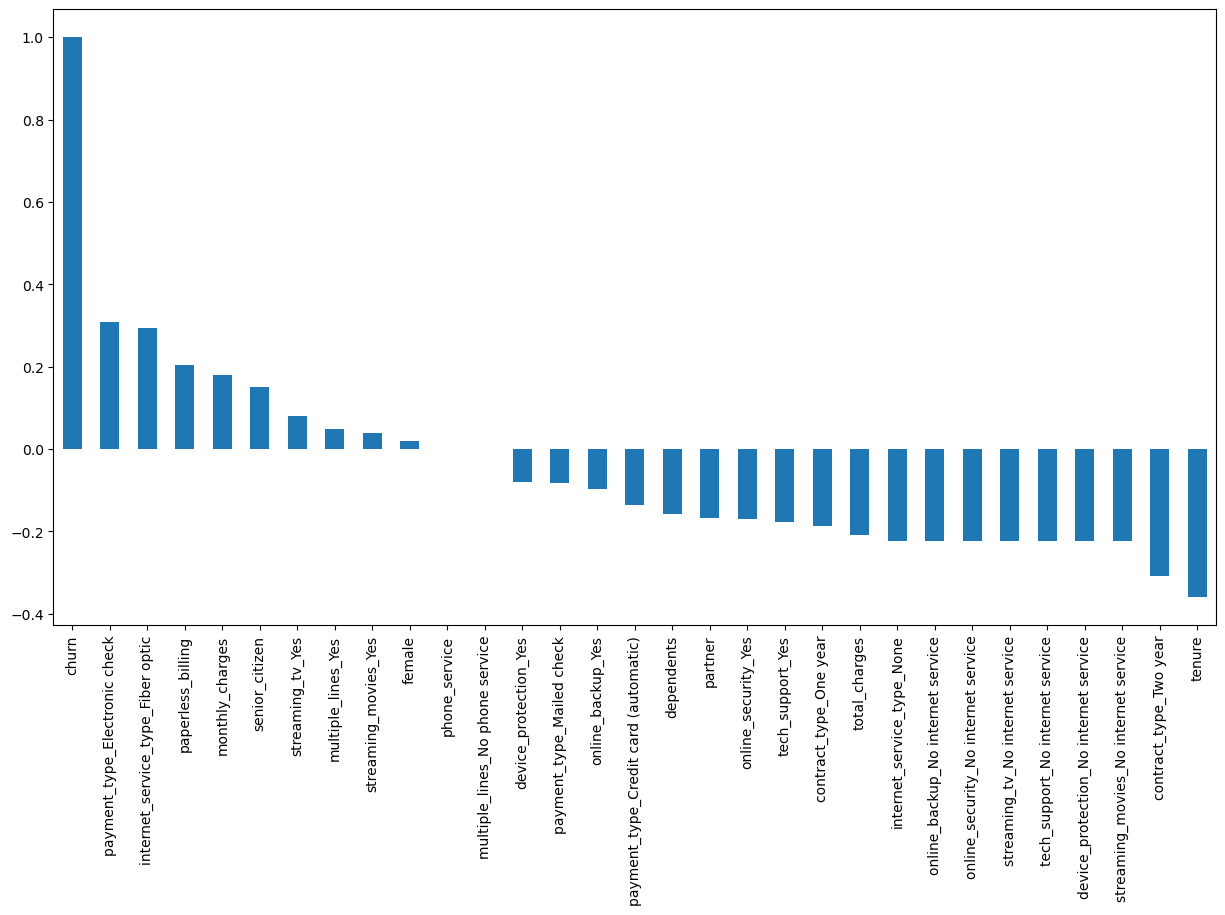

In [9]:
plt.figure(figsize=(15,8))
train.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

In [10]:
cat = ['internet_service_type_Fiber optic',
        'payment_type_Electronic check',
        'paperless_billing']
quant = ['monthly_charges']

In [11]:
# payment_type_Electronic check
# internet_service_type_Fiber optic
# paperless_billing
# monthly_charges

internet_service_type_Fiber optic 
_____________________

         chi2       p-value  degrees of freedom
0  361.413355  1.386218e-80                   1

observed:
 churn                                 0     1   All
internet_service_type_Fiber optic                  
0                                  1993   350  2343
1                                  1111   771  1882
All                                3104  1121  4225

expected:
              0           1
0  1721.342485  621.657515
1  1382.657515  499.342485


/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


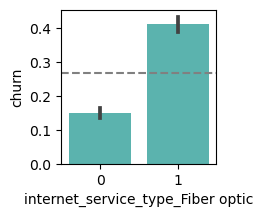


_____________________

payment_type_Electronic check 
_____________________

         chi2       p-value  degrees of freedom
0  403.890284  7.835717e-90                   1

observed:
 churn                             0     1   All
payment_type_Electronic check                  
0                              2344   476  2820
1                               760   645  1405
All                            3104  1121  4225

expected:
              0           1
0  2071.782249  748.217751
1  1032.217751  372.782249


/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


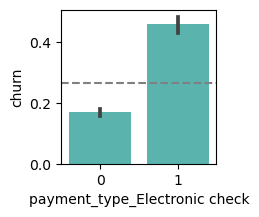


_____________________

paperless_billing 
_____________________



/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2       p-value  degrees of freedom
0  174.017067  9.814256e-40                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1414   258  1672
1                  1690   863  2553
All                3104  1121  4225

expected:
              0           1
0  1228.375858  443.624142
1  1875.624142  677.375858


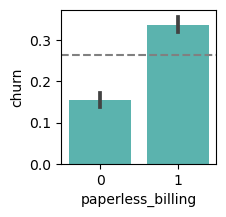


_____________________

monthly_charges 
____________________



/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


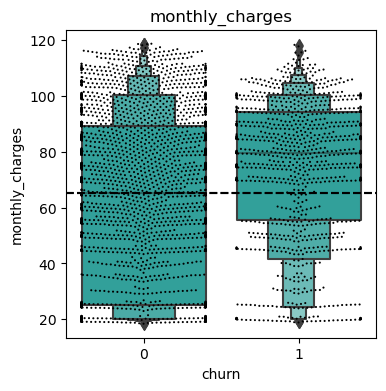

        count       mean        std    min   25%    50%    75%     max
churn                                                                 
0      3104.0  62.024017  31.275556  18.40  25.2  65.25  89.15  118.75
1      1121.0  74.270205  24.970601  18.85  55.7  79.60  94.20  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2128336.0, pvalue=1.261599899747347e-28)

____________________



In [12]:
e.explore_bivariate(train,'churn',cat,quant)

### 1) Is Churn independent from payment type?
* $H_0$: Churn is independent from payment type
* $H_a$: Churn is **NOT** independent from payment type
* Discrete (churn) vs Discrete (payment_type) = $Chi^2$
    - $Chi^2$ = 411.59356 
    - $p$ = 6.820556e-89
* `Churn` is **NOT** independent from `payment type`

Chi2: 411.5935596871652, p-value: 6.820556365758793e-89


/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


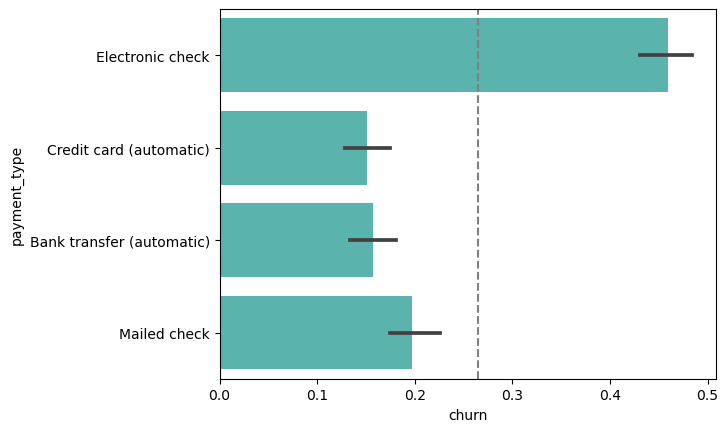

In [13]:
e.explore_cat(train,'churn','payment_type')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that payment type and churn are not independent from each other. I believe that using `payment_type` in the modeling will have a positive impact on the accuracy.**

### 2) Is Churn independent from internet Service type?
* $H_0$: Churn is independent from internet service type
* $H_a$: Churn is **NOT** independent from internet service type
* Discrete (churn) vs Discrete (internet_service_type) = $Chi^2$
    - $Chi^2$ = 402.162525
    - $p$ = 4.693721e-88
* `Churn` is **NOT** independent from `internet service type`

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Chi2: 402.162525170296, p-value: 4.693720719529299e-88


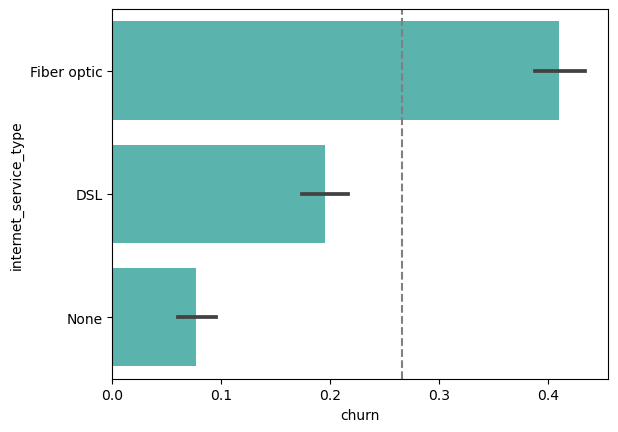

In [14]:
e.explore_cat(train,'churn','internet_service_type')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that internet service type and churn are not independent from each other. I believe that using `internet_service_type` in the modeling will have a positive impact on the accuracy.**

### 3) Is Churn independent from paperless billing?
* $H_0$: Churn is independent from paperless billing
* $H_a$: Churn is **NOT** independent from paperless billing
* Discrete (churn) vs Discrete (paperless billing) = $Chi^2$
    - $Chi^2$ = 174.0170668905212
    - $p$ = 9.814255558186946e-40
* `Churn` is **NOT** independent from `paperless billing`

Chi2: 174.0170668905212, p-value: 9.814255558186946e-40


/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


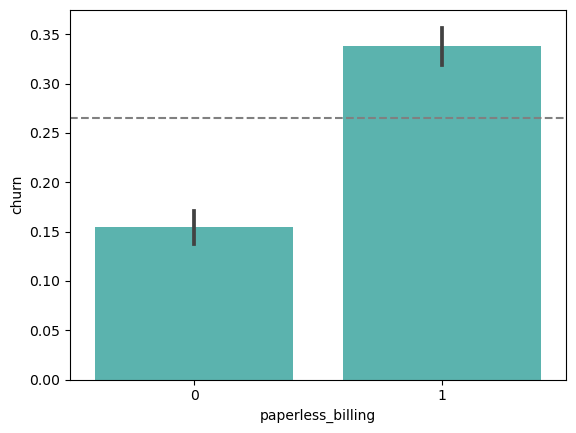

In [15]:
e.explore_int(train,'churn','paperless_billing')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that paperless billing and churn are not independent from each other. I believe that using `paperless_billing` in the modeling will have a positive impact on the accuracy.**

### 4) Is there a difference in Churn based on monthly charges?
* $H_0$: There is **NO** difference in Churn based on monthly charges
* $H_a$: There is a difference in Churn based on monthly charges
* Discrete (churn) vs Continuous (monthly_charges) = $Mann$-$Whitney$ $U$
    - $Mann$-$Whitney$ $U$ statistic = 1351248.0
    - $p$ = 1.261599899747347e-28
* There is a difference in `Churn` based on `monthly charges`

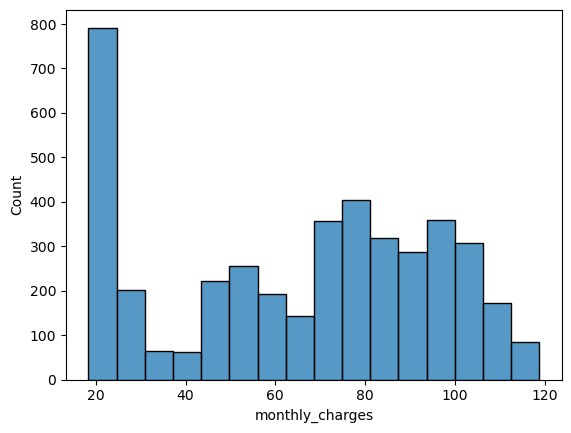

In [16]:
sns.histplot(data=train,x='monthly_charges')
plt.show()

monthly_charges 
____________________



/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


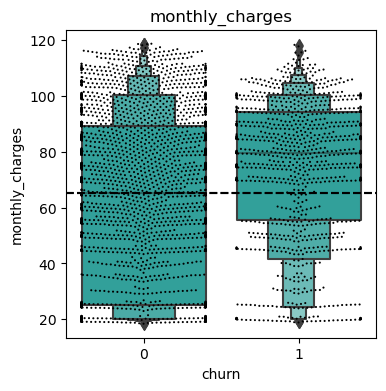

        count       mean        std    min   25%    50%    75%     max
churn                                                                 
0      3104.0  62.024017  31.275556  18.40  25.2  65.25  89.15  118.75
1      1121.0  74.270205  24.970601  18.85  55.7  79.60  94.20  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2128336.0, pvalue=1.261599899747347e-28)

____________________



In [17]:
e.explore_bivariate_quant(train,'churn','monthly_charges')

In [18]:
# H0: Churned has lower or equal monthly charges
# Ha: Churned has higher monthly charges <---
e.compare_means(train,'churn','monthly_charges','greater')

MannwhitneyuResult(statistic=2128336.0, pvalue=6.307999498736735e-29)

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that there is a difference in monthly charges between churned and active customers. In fact, monthly charges is greater on average for customers who have churned compared to monthly charges of customers who haven't. I believe that using `monthly_charges` in the modeling will have a positive impact on the accuracy.**

### Are there any features that are independent from Churn?
* `Churn` **is** independent from both `gender` and `phone_service`
* Discrete (churn) vs Discrete (gender) = $Chi^2$
    - $Chi^2$ = 1.4668271981736136 
    - $p$ = 0.22584695828761636
* $H_0$: Churn is independent from gender
* $H_a$: Churn is **NOT** independent from gender
* Discrete (churn) vs Discrete (phone_service) = $Chi^2$
    - $Chi^2$ = 0.0 
    - $p$ = 1.0
* $H_0$: Churn is independent from phone service
* $H_a$: Churn is **NOT** independent from phone service

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Chi2: 1.4668271981736136, p-value: 0.22584695828761636


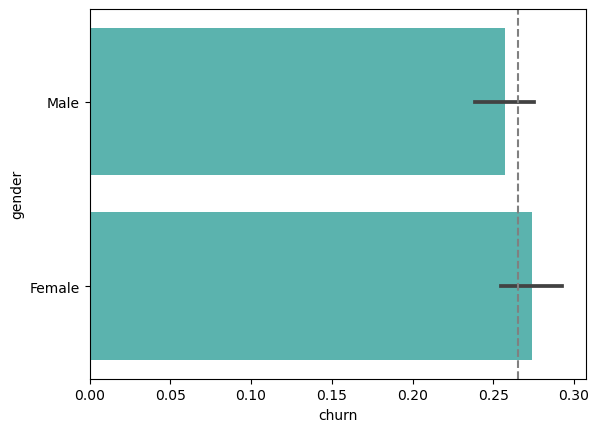

In [19]:
e.explore_cat(train,'churn','gender')

Chi2: 0.0, p-value: 1.0


/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


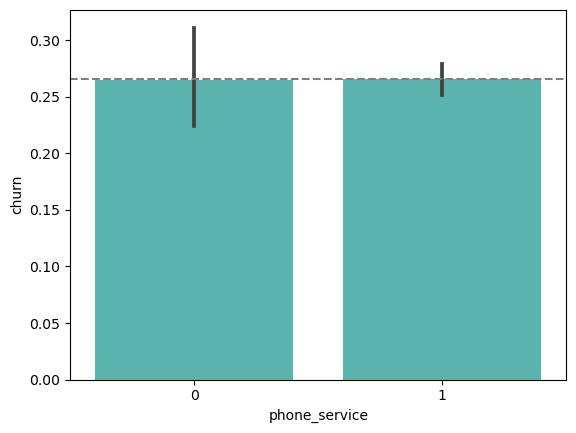

In [20]:
e.explore_int(train,'churn','phone_service')

**With an alpha of 0.05 (confidence 95%) the p-values are greater than alpha. Therefore, evidence suggests that gender and phone service vs churn are independent from each other. I believe that using `gender` and `phone_service` in the modeling will not have much of an impact on the accuracy.**

## You may use this as a template for how to ask and answer each question:

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by takeaways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

## Exploration Summary
* Payment type was found to be a driver of churn
    - Electronic check payment being the most common among churn
* Internet service type was found to be a driver of churn
    - Fiber optic internet being the most common among churn
* Paperless billing was found to be a driver of churn
    - Having paperless billing being the most common among churn
* Monthly charges was found to be a driver of churn
    - Higher average monthly charges amongst churn
* Gender and phone service were found to not be a driver of churn


* After your explore section, before you start modeling, provide a summary of your findings in Explore
* Include a summary of your takeaways
* Include a summary of the features you examined and weather or not you will be going to Modeling with each feature and why
* It is important to note which features will be going into your model so the reader knows what features you are using to model on

### Features for modeling
* Features that will be:
    - churn (target)
    - payment type
    - internet service type
    - paperless billing
    - monthly charges
* Features that will not be used
    - gender
    - phone service

## Modeling

* Accuracy will be the evaluation metric
* Recall will be the evaluation metric
    - This is to avoid FN, i.e., people that will probably be leaving but fail to detect them
* Target feature is Churn
    - 27% Churn
    - 73% Active
* Guessing Active for every customer gives an accuracy of 73%
    - 73% will be the baseline accuracy
* Models will be developed and evaluated using 4 different model types and various hyperparameter configurations
    - Decision Tree
    - Random Forest
    - KNN
    - Logistic Regression
* Models will be evaluated on train and validate datasets
* Best performing model will be the only one evaluated on the test dataset

In [21]:
e.baseline(train.churn)

Baseline: 73.47% Accuracy


### Introduction
* Explain how you will be evaluating your models
* Include the evaluation metric you will be using and why you have chosen it
* Create a baseline and briefly explain how it was calculated 

In [22]:
# If you use code to generate your baseline run the code and generate the output here

Printout should read: <br>
Baseline: "number" "evaluation metric"

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

### Model Type

In [23]:
# Code that runs the best model in that model type goes here 
# (This may be imported from a module)
tel_obj = train.select_dtypes(include='object').columns.to_list()
for i in ['churn','phone_service','female','multiple_lines_No phone service','multiple_lines_Yes']:
    tel_obj.append(i)
X_train = train.drop(columns=tel_obj)
X_validate = validate.drop(columns=tel_obj)
X_test = test.drop(columns=tel_obj)
y_train = train.churn
y_validate = validate.churn
y_test = test.churn

In [24]:
X_train.sample().T

,6890
senior_citizen,0.00
partner,1.00
dependents,1.00
paperless_billing,0.00
monthly_charges,63.55
total_charges,4014.20
tenure,63.00
online_security_No internet service,0.00
online_security_Yes,1.00
online_backup_No internet service,0.00


In [25]:
y_train.sample()

3431    0
Name: churn, dtype: int64

In [26]:
X_train.columns

Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'monthly_charges', 'total_charges', 'tenure',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'contract_type_One year', 'contract_type_Two year',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check'],
      dtype='object')

In [77]:
features1 = ['senior_citizen', 'partner', 'dependents', 'paperless_billing',
            'monthly_charges', 'total_charges', 'tenure',
            'online_security_No internet service', 'online_security_Yes',
            'online_backup_No internet service', 'online_backup_Yes',
            'device_protection_No internet service', 'device_protection_Yes',
            'tech_support_No internet service', 'tech_support_Yes',
            'streaming_tv_No internet service', 'streaming_tv_Yes',
            'streaming_movies_No internet service', 'streaming_movies_Yes',
            'contract_type_One year', 'contract_type_Two year',
            'internet_service_type_Fiber optic', 'internet_service_type_None',
            'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
            'payment_type_Mailed check']

features2 = ['senior_citizen','paperless_billing',
            'monthly_charges', 'total_charges', 'tenure',
            'contract_type_One year', 'contract_type_Two year',
            'internet_service_type_Fiber optic', 'internet_service_type_None',
            'payment_type_Credit card (automatic)']

features3 = ['monthly_charges', 'paperless_billing', 'internet_service_type_Fiber optic', 
            'payment_type_Electronic check']

In [58]:
metrics = []
for r in range(2,(len(features2)+1)):
    for feature,d in itertools.product(itertools.combinations(features2,r),range(1,11)):
        f = list(feature)
        # decision tree
        # model
        tree = DecisionTreeClassifier(max_depth=d,random_state=42)
        tree = tree.fit(X_train[f],y_train)
        # accuracies
        ytr_acc = tree.score(X_train[f],y_train)
        yv_acc = tree.score(X_validate[f],y_validate)
        # table-ize
        output = {
            'model':tree,
            'features':f,
            'train_acc':ytr_acc,
            'validate_acc':yv_acc
        }
        metrics.append(output)
df1 = pd.DataFrame(metrics)
df1['diff_score'] = abs(df1.train_acc - df1.validate_acc)
df1['avg_score'] = (df1.train_acc + df1.validate_acc)/2
df1

,model,features,train_acc,validate_acc,diff_score,avg_score
0,"DecisionTreeClassifier(max_depth=1, random_sta...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
1,"DecisionTreeClassifier(max_depth=2, random_sta...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
2,"DecisionTreeClassifier(max_depth=3, random_sta...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
3,"DecisionTreeClassifier(max_depth=4, random_sta...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
4,"DecisionTreeClassifier(max_depth=5, random_sta...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
...,...,...,...,...,...,...
10125,"DecisionTreeClassifier(max_depth=6, random_sta...","[senior_citizen, paperless_billing, monthly_ch...",0.821538,0.777147,0.044392,0.799343
10126,"DecisionTreeClassifier(max_depth=7, random_sta...","[senior_citizen, paperless_billing, monthly_ch...",0.829349,0.765082,0.064267,0.797215
10127,"DecisionTreeClassifier(max_depth=8, random_sta...","[senior_citizen, paperless_billing, monthly_ch...",0.842840,0.750177,0.092663,0.796509
10128,"DecisionTreeClassifier(max_depth=9, random_sta...","[senior_citizen, paperless_billing, monthly_ch...",0.861065,0.757984,0.103081,0.809525


In [59]:
metrics = []
# random forest
for features in [features1,features2,features3]:
    if features == features1:
        f='features1'
    elif features == features2:
        f='features2'
    else:
        f='features3'
    for l, d in itertools.product(range(1,11), range(1,11)):
        # random forest
        # model
        rf = RandomForestClassifier(min_samples_leaf=l,max_depth=d,random_state=42)
        rf.fit(X_train[features],y_train)
        # accuracies
        ytr_acc = rf.score(X_train[features],y_train)
        yv_acc = rf.score(X_validate[features],y_validate)
        # table-ize
        output = {
            'model':rf,
            'features':f,
            'train_acc':ytr_acc,
            'validate_acc':yv_acc
        }
        metrics.append(output)
df2 = pd.DataFrame(metrics)
df2['diff_score'] = abs(df2.train_acc - df2.validate_acc)
df2['avg_score'] = (df2.train_acc + df2.validate_acc)/2
df2

,model,features,train_acc,validate_acc,diff_score,avg_score
0,"(DecisionTreeClassifier(max_depth=1, max_featu...",features1,0.734675,0.734564,0.000111,0.734619
1,"(DecisionTreeClassifier(max_depth=2, max_featu...",features1,0.765207,0.760114,0.005094,0.762660
2,"(DecisionTreeClassifier(max_depth=3, max_featu...",features1,0.790296,0.782825,0.007471,0.786560
3,"(DecisionTreeClassifier(max_depth=4, max_featu...",features1,0.804260,0.784954,0.019306,0.794607
4,"(DecisionTreeClassifier(max_depth=5, max_featu...",features1,0.807811,0.785664,0.022147,0.796737
...,...,...,...,...,...,...
295,"(DecisionTreeClassifier(max_depth=6, max_featu...",features3,0.778462,0.755145,0.023316,0.766804
296,"(DecisionTreeClassifier(max_depth=7, max_featu...",features3,0.782485,0.751597,0.030888,0.767041
297,"(DecisionTreeClassifier(max_depth=8, max_featu...",features3,0.786509,0.750177,0.036331,0.768343
298,"(DecisionTreeClassifier(max_depth=9, max_featu...",features3,0.787456,0.750177,0.037278,0.768817


In [60]:
# knn
metrics = []
for features in [features1,features2,features3]:
    if features == features1:
        f='features1'
    elif features == features2:
        f='features2'
    else:
        f='features3'
    for n, w, a in itertools.product(range(1,21),['uniform','distance'],['auto','ball_tree','kd_tree','brute']):
        # knn
        # model
        k = KNeighborsClassifier(n_neighbors=n,weights=w,algorithm=a)
        k.fit(X_train[features], y_train)
        # accuracies
        train_score = k.score(X_train[features], y_train)
        validate_score = k.score(X_validate[features], y_validate)
        # table-ize
        output = {
            'model':k,
            'features':f,
            'train_acc':train_score,
            'validate_acc':validate_score
        }
        metrics.append(output)
#Put results into a dataframe
df3 = pd.DataFrame(metrics)
# Calculate the difference between the train and validation scores
df3['diff_score'] = abs(df3.train_acc - df3.validate_acc)
df3['avg_score'] = (df3.train_acc + df3.validate_acc)/2
df3

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

,model,features,train_acc,validate_acc,diff_score,avg_score
0,KNeighborsClassifier(n_neighbors=1),features1,0.997160,0.707594,0.289566,0.852377
1,"KNeighborsClassifier(algorithm='ball_tree', n_...",features1,0.997396,0.706175,0.291222,0.851786
2,"KNeighborsClassifier(algorithm='kd_tree', n_ne...",features1,0.997396,0.706175,0.291222,0.851786
3,"KNeighborsClassifier(algorithm='brute', n_neig...",features1,0.997160,0.707594,0.289566,0.852377
4,"KNeighborsClassifier(n_neighbors=1, weights='d...",features1,0.997160,0.707594,0.289566,0.852377
...,...,...,...,...,...,...
475,"KNeighborsClassifier(algorithm='brute', n_neig...",features3,0.775858,0.757984,0.017874,0.766921
476,"KNeighborsClassifier(n_neighbors=20, weights='...",features3,0.913609,0.707594,0.206015,0.810602
477,"KNeighborsClassifier(algorithm='ball_tree', n_...",features3,0.913609,0.709013,0.204596,0.811311
478,"KNeighborsClassifier(algorithm='kd_tree', n_ne...",features3,0.913609,0.707594,0.206015,0.810602


In [61]:
metrics = []
for r in range(2,(len(features2)+1)):
    for feature,c,cw in itertools.product(itertools.combinations(features2,r),[.01,.1,1,10,100,1000],[None,'balanced']):
        # logistic regression
        f = list(feature)
        l = LogisticRegression(C=c,class_weight=cw,random_state=42,max_iter=500)
        l.fit(X_train[f],y_train)
        ytr_score = l.score(X_train[f],y_train)
        yv_score = l.score(X_validate[f],y_validate)
        # table-ize
        output = {
            'model':l,
            'features':f,
            'train_acc':ytr_score,
            'validate_acc':yv_score
        }
        metrics.append(output)
#Put results into a dataframe
df4 = pd.DataFrame(metrics)
# Calculate the difference between the train and validation scores
df4['diff_score'] = abs(df4.train_acc - df4.validate_acc)
df4['avg_score'] = (df4.train_acc + df4.validate_acc)/2
df4

,model,features,train_acc,validate_acc,diff_score,avg_score
0,"LogisticRegression(C=0.01, max_iter=500, rando...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
1,"LogisticRegression(C=0.01, class_weight='balan...","[senior_citizen, paperless_billing]",0.538935,0.534422,0.004513,0.536678
2,"LogisticRegression(C=0.1, max_iter=500, random...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
3,"LogisticRegression(C=0.1, class_weight='balanc...","[senior_citizen, paperless_billing]",0.538935,0.534422,0.004513,0.536678
4,"LogisticRegression(C=1, max_iter=500, random_s...","[senior_citizen, paperless_billing]",0.734675,0.734564,0.000111,0.734619
...,...,...,...,...,...,...
12151,"LogisticRegression(C=10, class_weight='balance...","[senior_citizen, paperless_billing, monthly_ch...",0.736331,0.728886,0.007446,0.732609
12152,"LogisticRegression(C=100, max_iter=500, random...","[senior_citizen, paperless_billing, monthly_ch...",0.808284,0.779986,0.028298,0.794135
12153,"LogisticRegression(C=100, class_weight='balanc...","[senior_citizen, paperless_billing, monthly_ch...",0.742012,0.731015,0.010997,0.736513
12154,"LogisticRegression(C=1000, max_iter=500, rando...","[senior_citizen, paperless_billing, monthly_ch...",0.806154,0.778566,0.027587,0.792360


In [62]:
def score_plot(data, diff=0.1, score='validate_acc', score_v=.7):
    df = data[(data.diff_score<diff)&(data[score]>score_v)].sort_values([score, 'diff_score'], ascending=[False, True]).reset_index()
    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(df.index, df.train_acc, label='train', marker='o', color='blue')
    plt.plot(df.index, df.validate_acc, label='validation', marker='o', color='orange')
    plt.fill_between(df.index, df.train_acc, df.validate_acc, alpha=0.2, color='gray')
    plt.plot(df.index, df.avg_score, label='avg_score', marker='o', color='black')
    plt.xlabel('index', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Classification Model Performance', fontsize=18)
    plt.legend(fontsize=12)
    plt.show()
    return df

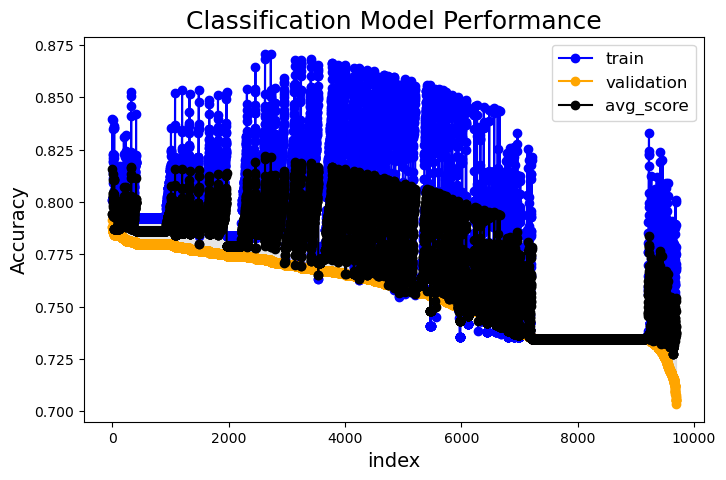

,index,model,features,train_acc,validate_acc,diff_score,avg_score
0,9117,"DecisionTreeClassifier(max_depth=8, random_sta...","[senior_citizen, monthly_charges, tenure, cont...",0.839763,0.791341,0.048422,0.815552
1,2304,"DecisionTreeClassifier(max_depth=5, random_sta...","[senior_citizen, tenure, contract_type_One yea...",0.800710,0.787793,0.012917,0.794251
2,4904,"DecisionTreeClassifier(max_depth=5, random_sta...","[senior_citizen, tenure, contract_type_One yea...",0.800710,0.787793,0.012917,0.794251
3,7479,"DecisionTreeClassifier(max_depth=10, random_st...","[senior_citizen, tenure, contract_type_One yea...",0.814201,0.787083,0.027118,0.800642
4,7207,"DecisionTreeClassifier(max_depth=8, random_sta...","[senior_citizen, monthly_charges, tenure, cont...",0.839290,0.787083,0.052207,0.813186
...,...,...,...,...,...,...,...
9685,239,"DecisionTreeClassifier(max_depth=10, random_st...","[monthly_charges, payment_type_Credit card (au...",0.768994,0.705465,0.063529,0.737229
9686,2139,"DecisionTreeClassifier(max_depth=10, random_st...","[senior_citizen, monthly_charges, internet_ser...",0.775148,0.705465,0.069683,0.740306
9687,2129,"DecisionTreeClassifier(max_depth=10, random_st...","[senior_citizen, monthly_charges, internet_ser...",0.799763,0.705465,0.094298,0.752614
9688,598,"DecisionTreeClassifier(max_depth=9, random_sta...","[senior_citizen, monthly_charges, payment_type...",0.770414,0.704755,0.065659,0.737585


In [63]:
#tree = 4937
score1 = score_plot(df1)
score1

In [91]:
f1 = df1.features.iloc[4937]
df1.model.iloc[4937]
f1

['senior_citizen',
 'tenure',
 'contract_type_Two year',
 'internet_service_type_Fiber optic',
 'payment_type_Credit card (automatic)']

In [72]:
m.dt(X_train,y_train,X_validate,y_validate,f1,8)

Decision Tree 

Accuracy on train: 80.64 

Accuracy on validate: 78.14


DecisionTreeClassifier(max_depth=8, random_state=42)

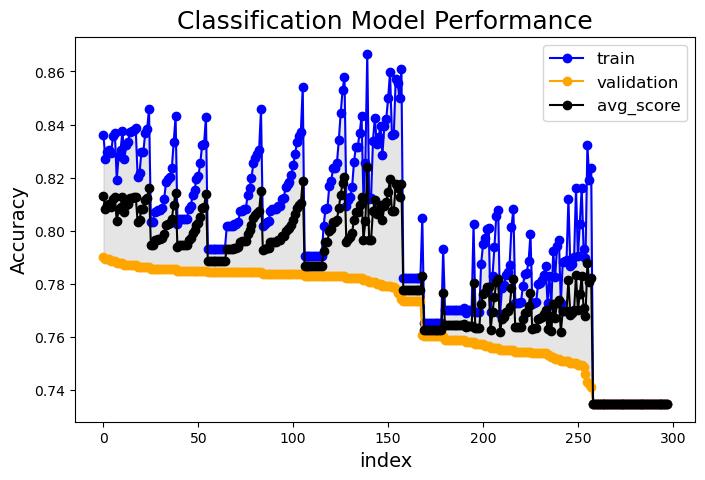

,index,model,features,train_acc,validate_acc,diff_score,avg_score
0,68,"(DecisionTreeClassifier(max_depth=9, max_featu...",features1,0.835976,0.789922,0.046054,0.812949
1,76,"(DecisionTreeClassifier(max_depth=7, max_featu...",features1,0.826982,0.789212,0.037770,0.808097
2,26,"(DecisionTreeClassifier(max_depth=7, max_featu...",features1,0.829822,0.789212,0.040610,0.809517
3,87,"(DecisionTreeClassifier(max_depth=8, max_featu...",features1,0.830533,0.789212,0.041320,0.809872
4,97,"(DecisionTreeClassifier(max_depth=8, max_featu...",features1,0.829112,0.788502,0.040610,0.808807
...,...,...,...,...,...,...,...
293,271,"(DecisionTreeClassifier(max_depth=2, max_featu...",features3,0.734675,0.734564,0.000111,0.734619
294,280,"(DecisionTreeClassifier(max_depth=1, max_featu...",features3,0.734675,0.734564,0.000111,0.734619
295,281,"(DecisionTreeClassifier(max_depth=2, max_featu...",features3,0.734675,0.734564,0.000111,0.734619
296,290,"(DecisionTreeClassifier(max_depth=1, max_featu...",features3,0.734675,0.734564,0.000111,0.734619


In [65]:
#rf = 26
score2 = score_plot(df2)
score2

In [92]:
f2 = features1
df2.model.iloc[26]
f2

['senior_citizen',
 'partner',
 'dependents',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'tenure',
 'online_security_No internet service',
 'online_security_Yes',
 'online_backup_No internet service',
 'online_backup_Yes',
 'device_protection_No internet service',
 'device_protection_Yes',
 'tech_support_No internet service',
 'tech_support_Yes',
 'streaming_tv_No internet service',
 'streaming_tv_Yes',
 'streaming_movies_No internet service',
 'streaming_movies_Yes',
 'contract_type_One year',
 'contract_type_Two year',
 'internet_service_type_Fiber optic',
 'internet_service_type_None',
 'payment_type_Credit card (automatic)',
 'payment_type_Electronic check',
 'payment_type_Mailed check']

In [81]:
m.rf(X_train,y_train,X_validate,y_validate,f2,3,7)

Random Forest 

Accuracy on train: 82.98 

Accuracy on validate: 78.92


RandomForestClassifier(max_depth=7, min_samples_leaf=3, random_state=42)

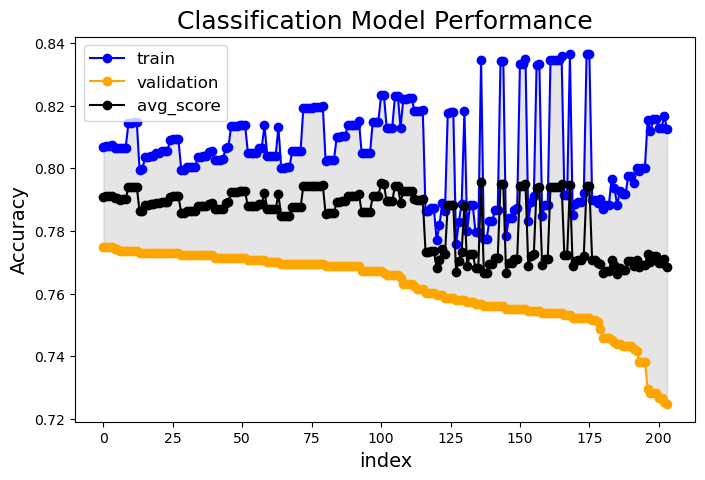

,index,model,features,train_acc,validate_acc,diff_score,avg_score
0,89,"KNeighborsClassifier(algorithm='ball_tree', n_...",features1,0.806864,0.775018,0.031846,0.790941
1,88,KNeighborsClassifier(n_neighbors=12),features1,0.807101,0.775018,0.032083,0.791059
2,91,"KNeighborsClassifier(algorithm='brute', n_neig...",features1,0.807101,0.775018,0.032083,0.791059
3,90,"KNeighborsClassifier(algorithm='kd_tree', n_ne...",features1,0.807337,0.775018,0.032320,0.791178
4,249,"KNeighborsClassifier(algorithm='ball_tree', n_...",features2,0.806627,0.774308,0.032319,0.790468
...,...,...,...,...,...,...,...
199,346,"KNeighborsClassifier(algorithm='kd_tree', n_ne...",features3,0.815621,0.728176,0.087445,0.771899
200,352,KNeighborsClassifier(),features3,0.813018,0.726757,0.086261,0.769887
201,354,KNeighborsClassifier(algorithm='kd_tree'),features3,0.813018,0.726757,0.086261,0.769887
202,347,"KNeighborsClassifier(algorithm='brute', n_neig...",features3,0.816568,0.725337,0.091231,0.770953


In [67]:
#knn = 272
score3 = score_plot(df3)
score3

In [93]:
f3 = features2
df3.model.iloc[272]
f3

['senior_citizen',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'tenure',
 'contract_type_One year',
 'contract_type_Two year',
 'internet_service_type_Fiber optic',
 'internet_service_type_None',
 'payment_type_Credit card (automatic)']

In [84]:
m.knn(X_train,y_train,X_validate,y_validate,f3,15,'uniform','auto')

Random Forest 

Accuracy on train: 80.54 

Accuracy on validate: 77.29


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

KNeighborsClassifier(n_neighbors=15)

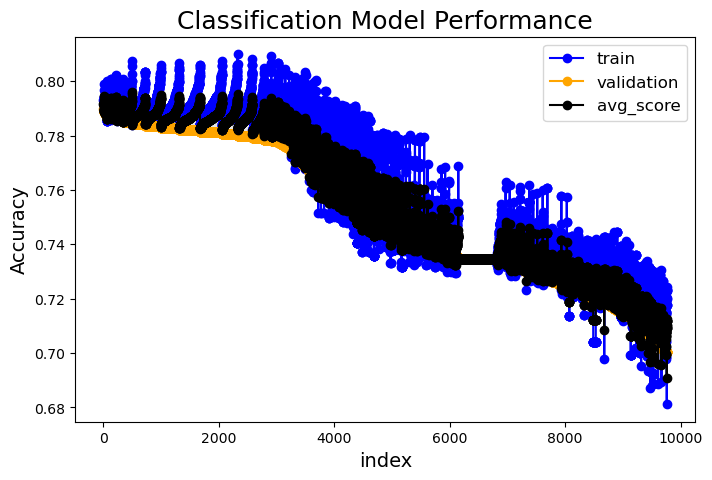

,index,model,features,train_acc,validate_acc,diff_score,avg_score
0,5234,"LogisticRegression(C=0.1, max_iter=500, random...","[senior_citizen, monthly_charges, total_charge...",0.793136,0.789922,0.003214,0.791529
1,5238,"LogisticRegression(C=10, max_iter=500, random_...","[senior_citizen, monthly_charges, total_charge...",0.793846,0.789922,0.003924,0.791884
2,5236,"LogisticRegression(C=1, max_iter=500, random_s...","[senior_citizen, monthly_charges, total_charge...",0.794083,0.789922,0.004161,0.792002
3,11836,"LogisticRegression(C=1, max_iter=500, random_s...","[senior_citizen, monthly_charges, total_charge...",0.799053,0.789922,0.009131,0.794488
4,8546,"LogisticRegression(C=0.1, max_iter=500, random...","[senior_citizen, monthly_charges, total_charge...",0.789112,0.789212,0.000100,0.789162
...,...,...,...,...,...,...,...
9762,7335,"LogisticRegression(C=0.1, class_weight='balanc...","[total_charges, tenure, contract_type_One year...",0.722840,0.700497,0.022343,0.711669
9763,8095,"LogisticRegression(C=10, class_weight='balance...","[senior_citizen, paperless_billing, total_char...",0.723314,0.700497,0.022817,0.711905
9764,8097,"LogisticRegression(C=100, class_weight='balanc...","[senior_citizen, paperless_billing, total_char...",0.723314,0.700497,0.022817,0.711905
9765,8099,"LogisticRegression(C=1000, class_weight='balan...","[senior_citizen, paperless_billing, total_char...",0.723314,0.700497,0.022817,0.711905


In [69]:
#lr = 8838
score4 = score_plot(df4)
score4

In [90]:
f4 = df4.features.iloc[8838]
df4.model.iloc[8838]
f4

['senior_citizen',
 'total_charges',
 'tenure',
 'contract_type_One year',
 'internet_service_type_Fiber optic',
 'payment_type_Credit card (automatic)']

In [86]:
m.lr(X_train,y_train,X_validate,y_validate,f4,10)

Random Forest 

Accuracy on train: 79.72 

Accuracy on validate: 78.57


LogisticRegression(C=10, max_iter=250, random_state=42)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [89]:
# Code that runs the best overall model on test data (this may be imported from a module)
# LogisticRegression(C=10,random_state=42,max_iter=500).fit(X_train[f4], y_train).score(X_test[f4], y_test)
m.test_model(X_train,y_train,X_test,y_test)

0.8069552874378992

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.

In [98]:
df = w.wrangle_telco_data()
train, validate, test = w.split_data(df, 'churn')
test.columns

csv file found and loaded
data cleaned and prepped
data split
train -> (4225, 43); 59.99%
validate -> (1409, 43); 20.01%
test -> (1409, 43); 20.01%


Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service_type',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type', 'payment_type',
       'paperless_billing', 'monthly_charges', 'total_charges', 'tenure',
       'churn', 'female', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_None', '

In [137]:
X_test = test.drop(columns=['customer_id','churn','gender','phone_service','female','multiple_lines','multiple_lines_No phone service','multiple_lines_Yes','internet_service_type',
        'online_security', 'online_backup', 'device_protection', 'tech_support',
        'streaming_tv', 'streaming_movies', 'contract_type', 'payment_type'])
y_test = test.churn
X_test

,senior_citizen,partner,dependents,paperless_billing,monthly_charges,total_charges,tenure,online_security_No internet service,online_security_Yes,online_backup_No internet service,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
455,0,1,0,0,28.50,629.35,21,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2301,1,0,0,1,111.40,1183.05,11,0,0,0,...,1,0,1,0,0,1,0,0,1,0
2255,1,0,0,0,69.35,261.65,4,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4527,0,0,0,0,19.95,107.05,5,1,0,1,...,0,1,0,0,0,0,1,0,0,1
3812,0,1,1,1,65.65,4664.50,72,0,1,0,...,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0,0,0,0,19.15,19.15,1,1,0,1,...,0,1,0,0,0,0,1,0,0,1
4510,0,0,0,1,80.50,232.35,3,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3910,0,0,0,1,55.25,55.25,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4820,0,1,1,0,74.80,1821.20,24,0,1,0,...,1,0,1,1,0,0,0,0,0,1


In [142]:
f4 = ['senior_citizen',
        'total_charges',
        'tenure',
        'contract_type_One year',
        'internet_service_type_Fiber optic',
        'payment_type_Credit card (automatic)']
l=LogisticRegression(C=10,random_state=42,max_iter=500)
l.fit(X_train[f4], y_train)
test_prob = l.predict_proba(X_test[f4])
test_pred = l.predict(X_test[f4])

In [143]:
p1 = pd.DataFrame(test['customer_id']).reset_index().drop(columns='index')
p2 = pd.DataFrame(test_prob).rename(columns={1:'churn_prob'}).drop(columns=0)
p3 = pd.DataFrame(test_pred).rename(columns={0:'churn_pred'})
pred_df = pd.concat([p1,p2,p3],axis=1)
pred_df.to_csv('predictions.csv', index=False)
